# **LV 2: Named Entity Recognition (NER)**
---

##  **1. Uvod u Named Entity Recognition**

**Named Entity Recognition (NER)** je zadatak iz područja *obrade prirodnog jezika (NLP)* gdje se iz teksta automatski prepoznaju i označavaju entiteti poput osoba, lokacija, organizacija, datuma itd.

### Najčešće korištene kategorije entiteta:
- **PERSON** – stvarne osobe
- **ORG** – organizacije, tvrtke, institucije
- **GPE** – političke jedinice (države, gradovi)
- **LOC** – lokacije koje nisu političke
- **DATE** – datumi
- **PRODUCT** – proizvodi
- **MONEY** – novčani iznosi

NER omogućuje da iz nestrukturiranog teksta izvučemo **strukturirane informacije**, što se koristi u:
- **analizi vijesti**
- **praćenju financijskih informacija**
- **analizi društvenih mreža**
- **izradi znanstvenih i tehnoloških baza podataka**
- **chatbotovima i tražilicama**

---


## **2. Korištene biblioteke**

U ovoj vježbi koristimo:

### spaCy
Biblioteka za obradu jezika, uključuje:
- pre-trainane NLP modele
- detekciju entiteta, tokenizaciju, lematizaciju...

### pandas
Za tablični prikaz izdvojenih entiteta.

### matplotlib
Za vizualizaciju frekvencija entiteta.

---


##  **3. Inicijalizacija okruženja i osnovni primjeri**

---



In [1]:
import spacy
from spacy.tokens import Span
import pandas as pd
import matplotlib.pyplot as plt

nlp = spacy.load('en_core_web_sm')

In [2]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 45.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### Primjer: *Osnovni NER u spaCy*
---
Demonstracija kako spaCy prepoznaje entitete iz jednostavnog teksta.


In [3]:
text_example1 = 'Lionel Messi plays for Inter Miami since 2023.'
doc = nlp(text_example1)
for ent in doc.ents:
    print(ent.text, ent.label_)

Messi PERSON
Inter Miami LOC
2023 DATE


### Primjer : *Filtriranje i prebrojavanje entiteta*

Ekstrakcija entiteta iz teksta koristi **pre-trained NLP model** koji kreira **Doc objekt** s tokenima i prepoznatim entitetima. Entitete je moguće filtrirati po tipovima koji nas zanimaju, prikazati ih s labelama ili vizualizirati te analizirati njihovu učestalost. Ovaj pristup omogućuje strukturiranje nestrukturiranog teksta i pripremu podataka za vizualizacije, izvještaje ili daljnju obradu u NLP aplikacijama.


In [4]:
text_example2 = """
Apple CEO Tim Cook met with European Union officials in Brussels. The meeting focused on digital privacy regulations planned for 2025.
"""

In [5]:
import spacy
nlp = spacy.load("en_core_web_sm")

doc = nlp(text_example2)

wanted = ["PERSON", "ORG", "GPE"]
filtered = [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in wanted]

print("Filtered entities:")
for ent, label in filtered:
    print(f"{ent} → {label}")

from collections import Counter

counts = Counter([ent.label_ for ent in doc.ents])
print("\nEntity counts:", counts)


Filtered entities:
Apple → ORG
Tim Cook → PERSON
European Union → ORG
Brussels → GPE

Entity counts: Counter({'ORG': 2, 'PERSON': 1, 'GPE': 1, 'DATE': 1})


### Primjer : *Ručno dodavanje entiteta*


U spaCy-u je moguće ručno dodati entitete u tekst koristeći **Span** i **doc.set_ents()**.
Ovo omogućuje označavanje entiteta koji model možda ne prepoznaje automatski te pripremu i kreiranje podataka za fine-tuning NER modela.



In [6]:
text_example3 = 'FERIT is a technical faculty known for its strong focus on electrical engineering, computer science, and information technologies. The institution provides modern laboratory facilities and supports a wide range of research and development projects. Students at FERIT work with contemporary technologies and practical examples that prepare them for careers in industry and academia. The faculty continually collaborates with local and international partners to ensure that its programs remain relevant and innovative.'

In [7]:
doc = nlp(text_example3)
ferit = Span(doc, 0, 1, label='ORG')
doc.set_ents([ferit])
[(ent.text, ent.label_) for ent in doc.ents]

[('FERIT', 'ORG')]

# **4. Fine-Tuning NER modela**

SpaCy omogućuje prilagođavanje postojećih modela na vlastite entitete. To znači da možemo:

- **Učiti model da prepozna entitete koji nisu u standardnom** (npr. vrste voća, životinje, proizvode).

- Dodavati nove kategorije entiteta (ner.add_label("NEW_ENTITY")).

- **Fine-tunirati** model na vlastitom malom datasetu koristeći Example.from_dict i nlp.update.

Prednosti fine-tuninga:

- Prepoznavanje entiteta specifičnih za vašu domenu

- Bolja točnost na vlastitim podacima

- Mogućnost kombiniranja sa **pre-trained modelima** da se sačuvaju postojeći entite

### Primjer : *Fine-tunning jednostavnog modela*


In [8]:
import spacy
from spacy.training import Example

TRAIN_DATA = [
    ("I ate an apple today.", {"entities": [(9, 14, "FRUIT")]}),
    ("Bananas are yellow.", {"entities": [(0, 7, "FRUIT")]}),
    ("I like to eat a banana.", {"entities": [(16, 22, "FRUIT")]}),
]

TEST_SENTENCE = "I ate an apple and a banana and Bananas."

nlp = spacy.load("en_core_web_md")
ner = nlp.get_pipe("ner")
ner.add_label("FRUIT")

print("=== BEFORE TRAINING ===")
doc_before = nlp(TEST_SENTENCE)
for ent in doc_before.ents:
    print(ent.text, ent.label_)


=== BEFORE TRAINING ===
Bananas GPE


In [9]:
other_pipes = [p for p in nlp.pipe_names if p != "ner"]
with nlp.disable_pipes(*other_pipes):
    optimizer = nlp.resume_training()
    for epoch in range(30):
        for text, ann in TRAIN_DATA:
            doc = nlp.make_doc(text)
            example = Example.from_dict(doc, ann)
            nlp.update([example], drop=0.2, sgd=optimizer)

print("=== AFTER TRAINING ===")
doc_after = nlp(TEST_SENTENCE)
for ent in doc_after.ents:
    print(ent.text, ent.label_)

=== AFTER TRAINING ===
apple FRUIT
banana FRUIT
Bananas FRUIT


# **ZADATCI**


# **Zadatak 1**: Izdvajanje entiteta iz teksta
---
### Tekst:
```
The European Space Agency (ESA) plans to launch satellites from Kourou, French Guiana.
Scientists from Cambridge and MIT support the project.
```
### **Ciljevi**:
1. **Pokrenuti NER** nad tekstom.  
2. **Ispisati sve entitete** prepoznate u tekstu.  
3. **Prikazati entitete** u **pandas tablici** za preglednu vizualizaciju

In [15]:
text_task1 = '''The European Space Agency (ESA) plans to launch satellites from Kourou, French Guiana. Scientists from Cambridge and MIT support the project.'''

doc = nlp(text_task1)

ents = []
for ent in doc.ents:
    ents.append({
        "text": ent.text,
        "label": ent.label_,
        "start_char": ent.start_char,
        "end_char": ent.end_char,
    })

df = pd.DataFrame(ents)
print(df)


                        text   label  start_char  end_char
0  The European Space Agency     ORG           0        25
1                     Kourou     GPE          64        70
2                     French    NORP          72        78
3                     Guiana  PERSON          79        85
4                  Cambridge     GPE         103       112
5                        MIT  ANIMAL         117       120


# **Zadatak 2**: Filtriranje entiteta
---


### Tekst:
```
On Monday, Silicon Valley, the heart of the global tech industry, witnessed a major announcement: Jennifer Collins was appointed as the new CEO of NextGen Robotics, a company headquartered in San Francisco. Collins, who previously worked as the Chief Operating Officer at TechNova Inc. in Seattle, is known for her innovative strategies and bold leadership style.

The appointment came after the sudden resignation of former CEO Mark Reynolds, who cited personal reasons for leaving the company. Analysts from Goldman Analytics in New York speculated that Reynolds’ departure might be linked to recent product delays in the company’s flagship AI-driven drones project.

Following the announcement, Collins held a press conference at the NextGen Robotics headquarters, where she emphasized the importance of teamwork and ethical AI development. “Our goal is to make robotics accessible to small businesses, while maintaining transparency and trust with our customers,” she said. Several journalists from The Tech Times and Global Innovations attended the event, asking about upcoming product launches in Europe and Asia.

Meanwhile, competitors such as RoboWorks Ltd. and FutureTech Solutions in Boston expressed interest in collaborating on industry-wide standards for AI safety. Experts believe that Collins’ appointment could accelerate such partnerships.

By the end of the week, stock prices for NextGen Robotics had risen slightly, reflecting investor confidence in the new leadership. Observers noted that while challenges remain, the company’s direction under Collins seems promising.

Conclusion: This change in leadership not only impacts NextGen Robotics but also signals a broader shift in the tech industry, highlighting the growing importance of ethical practices and collaboration in AI development.
```


### **Ciljevi**:
1. **Pokrenuti NER** nad zadanim tekstom.  
2. **Izdvojiti entitete**: osoba,organizacija i lokacija    
3. Uzmi jednu rečenicu iz teksta i prikaži prepoznate entitete pomoću **spaCy-ove vizualizacije**
4. **Usporediti** prepoznate entitete s izvornim tekstom, navesti ispravne i eventualno pogrešno prepoznate entitete te napisati kratak zaključak o **točnosti modela** i mogućim poboljšanjima

In [16]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")

text = """
On Monday, Silicon Valley, the heart of the global tech industry, witnessed a major announcement: Jennifer Collins was appointed as the new CEO of NextGen Robotics, a company headquartered in San Francisco. Collins, who previously worked as the Chief Operating Officer at TechNova Inc. in Seattle, is known for her innovative strategies and bold leadership style.

The appointment came after the sudden resignation of former CEO Mark Reynolds, who cited personal reasons for leaving the company. Analysts from Goldman Analytics in New York speculated that Reynolds’ departure might be linked to recent product delays in the company’s flagship AI-driven drones project.

Following the announcement, Collins held a press conference at the NextGen Robotics headquarters, where she emphasized the importance of teamwork and ethical AI development. “Our goal is to make robotics accessible to small businesses, while maintaining transparency and trust with our customers,” she said. Several journalists from The Tech Times and Global Innovations attended the event, asking about upcoming product launches in Europe and Asia.

Meanwhile, competitors such as RoboWorks Ltd. and FutureTech Solutions in Boston expressed interest in collaborating on industry-wide standards for AI safety. Experts believe that Collins’ appointment could accelerate such partnerships.

By the end of the week, stock prices for NextGen Robotics had risen slightly, reflecting investor confidence in the new leadership. Observers noted that while challenges remain, the company’s direction under Collins seems promising.

Conclusion: This change in leadership not only impacts NextGen Robotics but also signals a broader shift in the tech industry, highlighting the growing importance of ethical practices and collaboration in AI development.
"""

doc = nlp(text)

wanted = ["PERSON", "ORG", "GPE"]
filtered = [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in wanted]

print("Filtered entities:")
for ent_text, label in filtered:
    print(ent_text, "->", label)

first_sent = list(doc.sents)[1]
displacy.render(first_sent, style="ent", jupyter=True)


Filtered entities:
Jennifer Collins -> PERSON
NextGen Robotics -> ORG
San Francisco -> GPE
Collins -> PERSON
TechNova Inc. -> ORG
Seattle -> GPE
Mark Reynolds -> PERSON
Goldman Analytics -> ORG
New York -> GPE
Reynolds -> ORG
AI -> GPE
Collins -> PERSON
The Tech Times -> ORG
Global Innovations -> ORG
RoboWorks Ltd. -> ORG
FutureTech Solutions -> ORG
Boston -> GPE
AI -> GPE
Collins -> PERSON
NextGen Robotics -> ORG
Collins -> PERSON
NextGen Robotics -> ORG
AI -> GPE


# **Zadatak 3**: Kombinacija predefiniranih i ručno dodanih entiteta
---


### **Tekst:**
```
OpenAI developed ChatGPT, a large language model.
Elon Musk and Sam Altman were involved in the project.
The model is used by companies such as Microsoft, Google, and Apple.
It can generate text, summarize articles, and even write code.
The headquarters are in San Francisco, California.
```

### **Ciljevi:**

1. Pokrenuti NER nad zadanim tekstom.

2. Dodati entitet **PRODUCT** za "ChatGPT" u dokument.

3. Izdvojiti entitete oznaka **ORG**, **PERSON**, **GPE** i **PRODUCT**.

4. Spremiti entitete u rječnik prema tipu entiteta (`ent_dict`).

5. Vizualizirati broj entiteta po kategorijama u **bar chart** pomoću pandas i matplotlib.
6. Napisati kratak zaključak o **preciznosti** NER-a i **korisnosti vizualizacije**

{'ORG': ['OpenAI', 'Microsoft', 'Google', 'Apple'], 'PERSON': ['Elon Musk', 'Sam Altman'], 'GPE': ['San Francisco', 'California'], 'PRODUCT': ['ChatGPT']}
     label  count
0      ORG      4
1   PERSON      2
2      GPE      2
3  PRODUCT      1


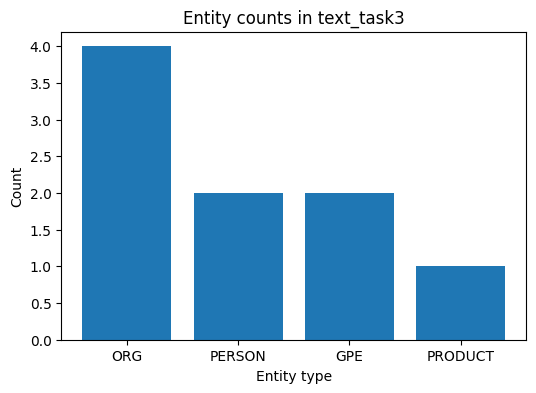

In [12]:
import spacy
from spacy.tokens import Span
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

text_task3 = '''OpenAI developed ChatGPT, a large language model.
Elon Musk and Sam Altman were involved in the project.
The model is used by companies such as Microsoft, Google, and Apple.
It can generate text, summarize articles, and even write code.
The headquarters are in San Francisco, California.'''

doc = nlp(text_task3)

doc = nlp(text_task3)
chatgpt_span = None
for sent in doc.sents:
    if "ChatGPT" in sent.text:
        for token in sent:
            if token.text == "ChatGPT":
                chatgpt_span = Span(doc, token.i, token.i+1, label="PRODUCT")
                break

if chatgpt_span:
    new_ents = list(doc.ents) + [chatgpt_span]
    doc.set_ents(new_ents)

wanted_labels = ["ORG", "PERSON", "GPE", "PRODUCT"]

ent_dict = {label: [] for label in wanted_labels}
for ent in doc.ents:
    if ent.label_ in wanted_labels:
        ent_dict[ent.label_].append(ent.text)

print(ent_dict)

# bar chart
rows = []
for label, values in ent_dict.items():
    rows.append({"label": label, "count": len(values)})

df = pd.DataFrame(rows)
print(df)

plt.figure(figsize=(6,4))
plt.bar(df["label"], df["count"])
plt.xlabel("Entity type")
plt.ylabel("Count")
plt.title("Entity counts in text_task3")
plt.show()


Model prepoznaje organizacije i poznate osobe, dok proizvod chatgpt ne prepoznaje toliko dobro pa ga treba rucno upisat kao product. Bar chart pokazuje objašnjeno te vidimo koji se tipovi najviše i najbolje preopznavaju.

# **Zadatak 4**: Fine-Tuning NER Modela za Prepoznavanje Životinja




U ovom zadatku imate mali **training set** sa rečenicama u kojima se spominju životinje.  
Cilj je **fine-tunirati spaCy NER model** tako da prepoznaje entitete tipa **`ANIMAL`** u tekstu.

Koristite pre-trained model **`en_core_web_md`**.  

U trening setu entiteti su već anotirani (offseti + label).  
Prikazali smo kako model prepoznaje entitete prije treniranja (**BEFORE TRAINING**).

### **Ciljevi**:
1. **Dodati labelu `ANIMAL`** u NER na osnovu zadanog trening seta  
2. **Fine-tunirati model** da nauči prepoznati životinje  
3. **Testirati model** na primjeru rečenice, npr. "The dog chased the cat near my house."  
4. Razmisliti i navesti kako bi se ovaj pristup mogao koristiti u nekoj stvarnoj primjeni  


In [13]:
import spacy
from spacy.training import Example
from spacy import displacy
import random

TRAIN_DATA = [
    ("The cat sat on the mat.", {"entities": [(4, 7, "ANIMAL")]}),
    ("A dog barked loudly in the street.", {"entities": [(2, 5, "ANIMAL")]}),
    ("I saw an elephant at the zoo.", {"entities": [(8, 16, "ANIMAL")]}),
    ("The tiger was sleeping under a tree.", {"entities": [(4, 9, "ANIMAL")]}),
    ("A small dog chased the cat.", {"entities": [(8, 11, "ANIMAL"), (22, 25, "ANIMAL")]}),
]

TEST_SENTENCE = "The dog chased the cat near my house."

nlp = spacy.load("en_core_web_md")
ner = nlp.get_pipe("ner")
ner.add_label("ANIMAL")

print("=== BEFORE TRAINING ===")
doc_before = nlp(TEST_SENTENCE)
displacy.render(doc_before, style="ent", jupyter=True)

other_pipes = [p for p in nlp.pipe_names if p != "ner"]
with nlp.disable_pipes(*other_pipes):
    optimizer = nlp.resume_training()
    for epoch in range(30):
        random.shuffle(TRAIN_DATA)
        losses = {}
        for text, ann in TRAIN_DATA:
            doc = nlp.make_doc(text)
            example = Example.from_dict(doc, ann)
            nlp.update([example], sgd=optimizer, drop=0.2, losses=losses)

print("=== AFTER TRAINING ===")
doc_after = nlp(TEST_SENTENCE)
displacy.render(doc_after, style="ent", jupyter=True)

for ent in doc_after.ents:
    print(ent.text, ent.label_)


=== BEFORE TRAINING ===


/usr/local/lib/python3.12/dist-packages/spacy/displacy/__init__.py:215: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


/usr/local/lib/python3.12/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "A small dog chased the cat." with entities "[(8, 11, 'ANIMAL'), (22, 25, 'ANIMAL')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "I saw an elephant at the zoo." with entities "[(8, 16, 'ANIMAL')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


=== AFTER TRAINING ===


dog ANIMAL
cat ANIMAL
